In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import pickle
from pathlib import Path

In [2]:
path = Path('../data/asd/raw')
freqs = np.linspace(4, 12, 41)

info = pd.read_csv(path / 'path_file.csv')
info['fn'] = info['fn'].str.replace('и' + chr(774), 'й') # For some reason, filenames encode й as 2 unicode characters
info = info.groupby("fn").filter(lambda x: len(x) == 1)
typical = np.where(info['target'] == 'typical')[0]
asd = np.where(info['target'] == 'asd')[0]

eegs = {i: mne.io.read_raw_fif(path / fn, verbose=False) for i, fn in info['fn'].items()}
ch_names = eegs[0].ch_names

assert np.all([eegs[i].info['sfreq'] == sfreq for i, sfreq in info['sfreq'].items()])
info

fn   target dataset_name  sfreq  \
0      sedrykyn_sasha_7_og_concat_19.raw.fif      asd          asd    125   
1       roma gritchin _5_fon_open_19.raw.fif      asd          asd    125   
2                 boy5_asd_og_new_19.raw.fif      asd          asd    125   
3    viflyancev_4_asd_fon__concat_19.raw.fif      asd          asd    125   
4         andrey_matveev3_asd_new_19.raw.fif      asd          asd    125   
..                                       ...      ...          ...    ...   
330            artem_sarkis_6_fon_19.raw.fif  typical      typical    125   
331               gusarova_9_norm_19.raw.fif  typical      typical    125   
332     акулов миша 10 от даши_ог_19.raw.fif  typical      typical    125   
333                      жавнис_3_19.raw.fif  typical      typical    125   
334           никита 7 от даши_ог_19.raw.fif  typical      typical    125   

     age  seconds  
0      7     47.0  
1      5     33.0  
2      5     50.0  
3      4     58.0  
4      3     50.0  
..   ...      ...  
330    6     44.0  
331    9     83.0  
332   10     42.0  
333    3    386.0  
334    7     57.0  

[327 rows x 6 columns]

In [4]:
import sys
sys.path.append('../')

from pipeline.features import get_merged_df
from pipeline import models, validation
from sklearn.metrics import roc_auc_score

In [5]:
features_path = Path('../data/asd/features')
feature_methods = [
    'env-alpha',
    'env-beta',
    'coh-alpha',
    'coh-beta',
    'bands',
    # 'env-theta',
    # 'coh-theta',
    # 'psi'
]

In [6]:
data = get_merged_df(features_path / 'all_0_0_20', feature_methods)
features = list(data.columns.difference(['fn', 'target']))
data['target'] = data['target'] == 'asd'
data = data.join(info[['fn', 'age']].set_index('fn'), on='fn')
data

env_alpha_Fp1_Fp2  env_alpha_Fp1_F7  env_alpha_Fp1_F3  env_alpha_Fp1_Fz  \
0             0.894301          0.524368          0.817223          0.711028   
1             0.134027          0.461620          0.472063          0.882474   
2             0.389974          0.679241          0.912563          0.994476   
3             0.597099          0.348386          0.460732          0.398180   
4             0.232039          0.593211          0.530407          0.427668   
..                 ...               ...               ...               ...   
322           0.295342          0.680750          0.506854          0.665349   
323           0.063303          0.880142          0.943654          0.677545   
324           0.589293          0.425642          0.641269          0.647030   
325           0.547833          0.671194          0.671658          0.746955   
326           0.353539          0.701237          0.581034          0.363764   

     env_alpha_Fp1_F4  env_alpha_Fp1_F8  env_alpha_Fp1_T3  env_alpha_Fp1_C3  \
0            0.534992          0.641244          0.451378          0.413385   
1            0.140260          0.128484          0.300010          0.320836   
2            0.138644          0.210552          0.158212         -0.060223   
3           -0.182316          0.091121          0.213839          0.318115   
4           -0.026946          0.044114          0.298576          0.234543   
..                ...               ...               ...               ...   
322          0.355128          0.306866          0.164497          0.245771   
323          0.024405          0.137327          0.682872          0.417101   
324          0.332940          0.283482          0.354599          0.235146   
325          0.340495          0.246346          0.212733          0.142256   
326          0.240924          0.279541          0.188904          0.124152   

     env_alpha_Fp1_Cz  env_alpha_Fp1_C4  ...  bands_beta_Pz  bands_alpha_P4  \
0            0.353105          0.307792  ...       0.107455        0.134028   
1            0.082824          0.141817  ...       0.185615        0.160787   
2            0.012387         -0.005151  ...       0.099079        0.086513   
3           -0.048845         -0.050269  ...       0.055385        0.081833   
4            0.029659         -0.007099  ...       0.217407        0.105205   
..                ...               ...  ...            ...             ...   
322          0.117259          0.222935  ...       0.117509        0.175355   
323          0.600765          0.008430  ...       0.124859        0.356744   
324          0.264547          0.372298  ...       0.226413        0.117956   
325          0.081973          0.176395  ...       0.071533        0.140900   
326          0.058210         -0.042883  ...       0.163567        0.093547   

     bands_beta_P4  bands_alpha_T6  bands_beta_T6  bands_alpha_O1  \
0         0.098581        0.148476       0.118601        0.172558   
1         0.145909        0.092589       0.234765        0.134004   
2         0.133634        0.092880       0.206056        0.077225   
3         0.084228        0.083396       0.150227        0.080598   
4         0.235625        0.106891       0.711488        0.161248   
..             ...             ...            ...             ...   
322       0.051322        0.165843       0.073415        0.054644   
323       0.125602        0.265229       0.140604        0.210175   
324       0.201347        0.132947       0.354662        0.131131   
325       0.084020        0.090539       0.125414        0.076485   
326       0.173807        0.080851       0.239925        0.111549   

     bands_beta_O1  bands_alpha_O2  bands_beta_O2  age  
0         0.115668        0.137518       0.103735    7  
1         0.196179        0.126407       0.191845    5  
2         0.275413        0.068992       0.146905    5  
3         0.166482        0.091104       0.139684    4  
4         0.575508        0.1683

In [7]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

age_groups = {'2-4': range(2, 5),
              '5-6': range(5, 7),
              '7-9': range(7, 10),
              '10+': range(10, 20)}

classifiers = {'LR': models.LRScaled(), 'SVM': models.SVMScaled(),
               'XGB': XGBClassifier(max_depth=4, n_estimators=30, n_jobs=-1, objective='binary:logistic',use_label_encoder=False, eval_metric='error'),
               'RF': RandomForestClassifier(n_estimators=30, max_depth=2, n_jobs=-1)}

In [ ]:
selected_features = {}
scores = {}
feature_selection_results = {}

for model_name, model in classifiers.items():
    for ag_name, ag in age_groups.items():
        df = data[data['age'].isin(ag)].copy().reset_index(False)
        method = validation.NestedCrossValidator(df, features, model, p_bar=1, random_state=57, n_splits=5, n_repeats=5)
        selected_features[ag_name, model_name], scores[ag_name, model_name] = method.get_features()
        score = scores[ag_name, model_name]
        feature_selection_results[ag_name, model_name] = [np.mean(score.roc_aucs), np.std(score.roc_aucs), np.mean(score.accs), np.std(score.accs)]
        scores_df = pd.DataFrame(feature_selection_results, index=['roc-auc mean', 'roc-auc std', 'accuracy mean', 'accuracy std']).T
        scores_df.to_csv('ASD feature selection scores.csv')

with open('selected_features.pickle', 'wb') as f:
    pickle.dump(selected_features, f)

with open('scores.pickle', 'wb') as f:
    pickle.dump(scores, f)

## Clustering

In [35]:
ag_name = '2-4'
ag = age_groups[ag_name]
df = data[data['age'].isin(ag)]
rows = []

for feature in features:
    score = roc_auc_score(df['target'], df[feature].fillna(0))
    rows.append(max(score, 1 - score))

performance = pd.Series(rows, index=features, name='roc_auc')
performance.sort_values(ascending=False, inplace=True)


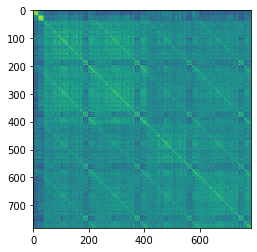

In [36]:
corr = df[features].fillna(0).corr().dropna(how='all', axis=0).dropna(how='all', axis=1)
plt.imshow(corr)

In [56]:
from sklearn.cluster import AgglomerativeClustering

clus = AgglomerativeClustering(n_clusters=None, affinity='precomputed', distance_threshold=0.4, linkage='single')

In [50]:
tr[n_clusters < 100]

array([0.31034483, 0.34482759, 0.37931034, 0.4137931 , 0.44827586,
       0.48275862, 0.51724138, 0.55172414, 0.5862069 , 0.62068966,
       0.65517241, 0.68965517, 0.72413793, 0.75862069, 0.79310345,
       0.82758621, 0.86206897, 0.89655172, 0.93103448, 0.96551724,
       1.        ])

In [57]:
clusters = pd.Series(clus.fit_predict(np.clip(1 - corr, 0, None)), index=corr.columns)
clusters.nunique()

11

## Feature visualization

In [12]:
montage = mne.channels.make_standard_montage('standard_1020')

# create Info object to store info
info = mne.io.meas_info.create_info(montage.ch_names, sfreq=256, ch_types="eeg")
# using temporary RawArray to apply mongage to info
mne.io.RawArray(np.zeros((len(montage.ch_names), 1)), info, copy=None).set_montage(montage)

# pick channels
channels_to_use_ = [ch for ch in info.ch_names if ch in ch_names]
info.pick_channels(channels_to_use_);

# get positions
_, pos, _, ch_names, _, _, _ = mne.viz.topomap._prepare_topomap_plot(info, 'eeg');
pos = pd.DataFrame(pos, columns=['x', 'y'], index=ch_names)

Creating RawArray with float64 data, n_channels=94, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


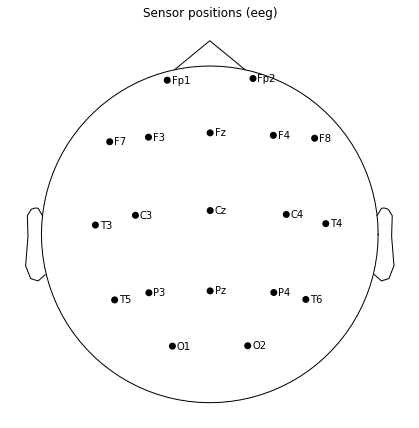

In [13]:
mne.viz.utils.plot_sensors(info, show_names=True, show=False)
plt.tight_layout()

In [14]:
from itertools import product
feature_types = list(map('_'.join, product(('coh', 'env', 'bands'), ('alpha', 'beta'))))

def parse_features(features):
    result = {k: [] for k in feature_types}
    for feature in features:
        split = feature.split('_')
        result['_'.join(split[:2])].append(split[2:])
    return result

def parse_feature_counts(features):
    result = {k: {} for k in feature_types}
    for feature, count in features.items():
        split = feature.split('_')
        result['_'.join(split[:2])][tuple(split[2:])] = count
    return result

In [15]:

def flatten(lst: list[list]) -> list:
    flat = []
    for lst_ in lst:
        flat.extend(lst_)
    return flat

def plot_features_type(channels, ax):
    if not channels:
        return
    dots = pos.loc[flatten(channels)]
    ax.scatter(*dots.values.T, s=300, alpha=0.5, c='orange')
    if len(channels[0]) == 2:
        for pair in channels:
            ax.plot(*pos.loc[pair].values.T, lw=2, c='orange')

def annotate_counts(channels, ax):
    for chans, count in channels.items():
        ax.annotate(count, pos.loc[list(chans)].mean(axis=0))

In [16]:
def plot_features_fold(features, axes):
    for (type_, chans), ax in zip(parse_features(features).items(), axes):
        mne.viz.utils.plot_sensors(info, show_names=False, show=False, axes=ax, title=type_)
        plot_features_type(chans, ax)

def plot_featues_agg(features, axes):
    plot_features_fold(features, axes)
    for channels, ax in zip(parse_feature_counts(features).values(), axes):
        annotate_counts(channels, ax)

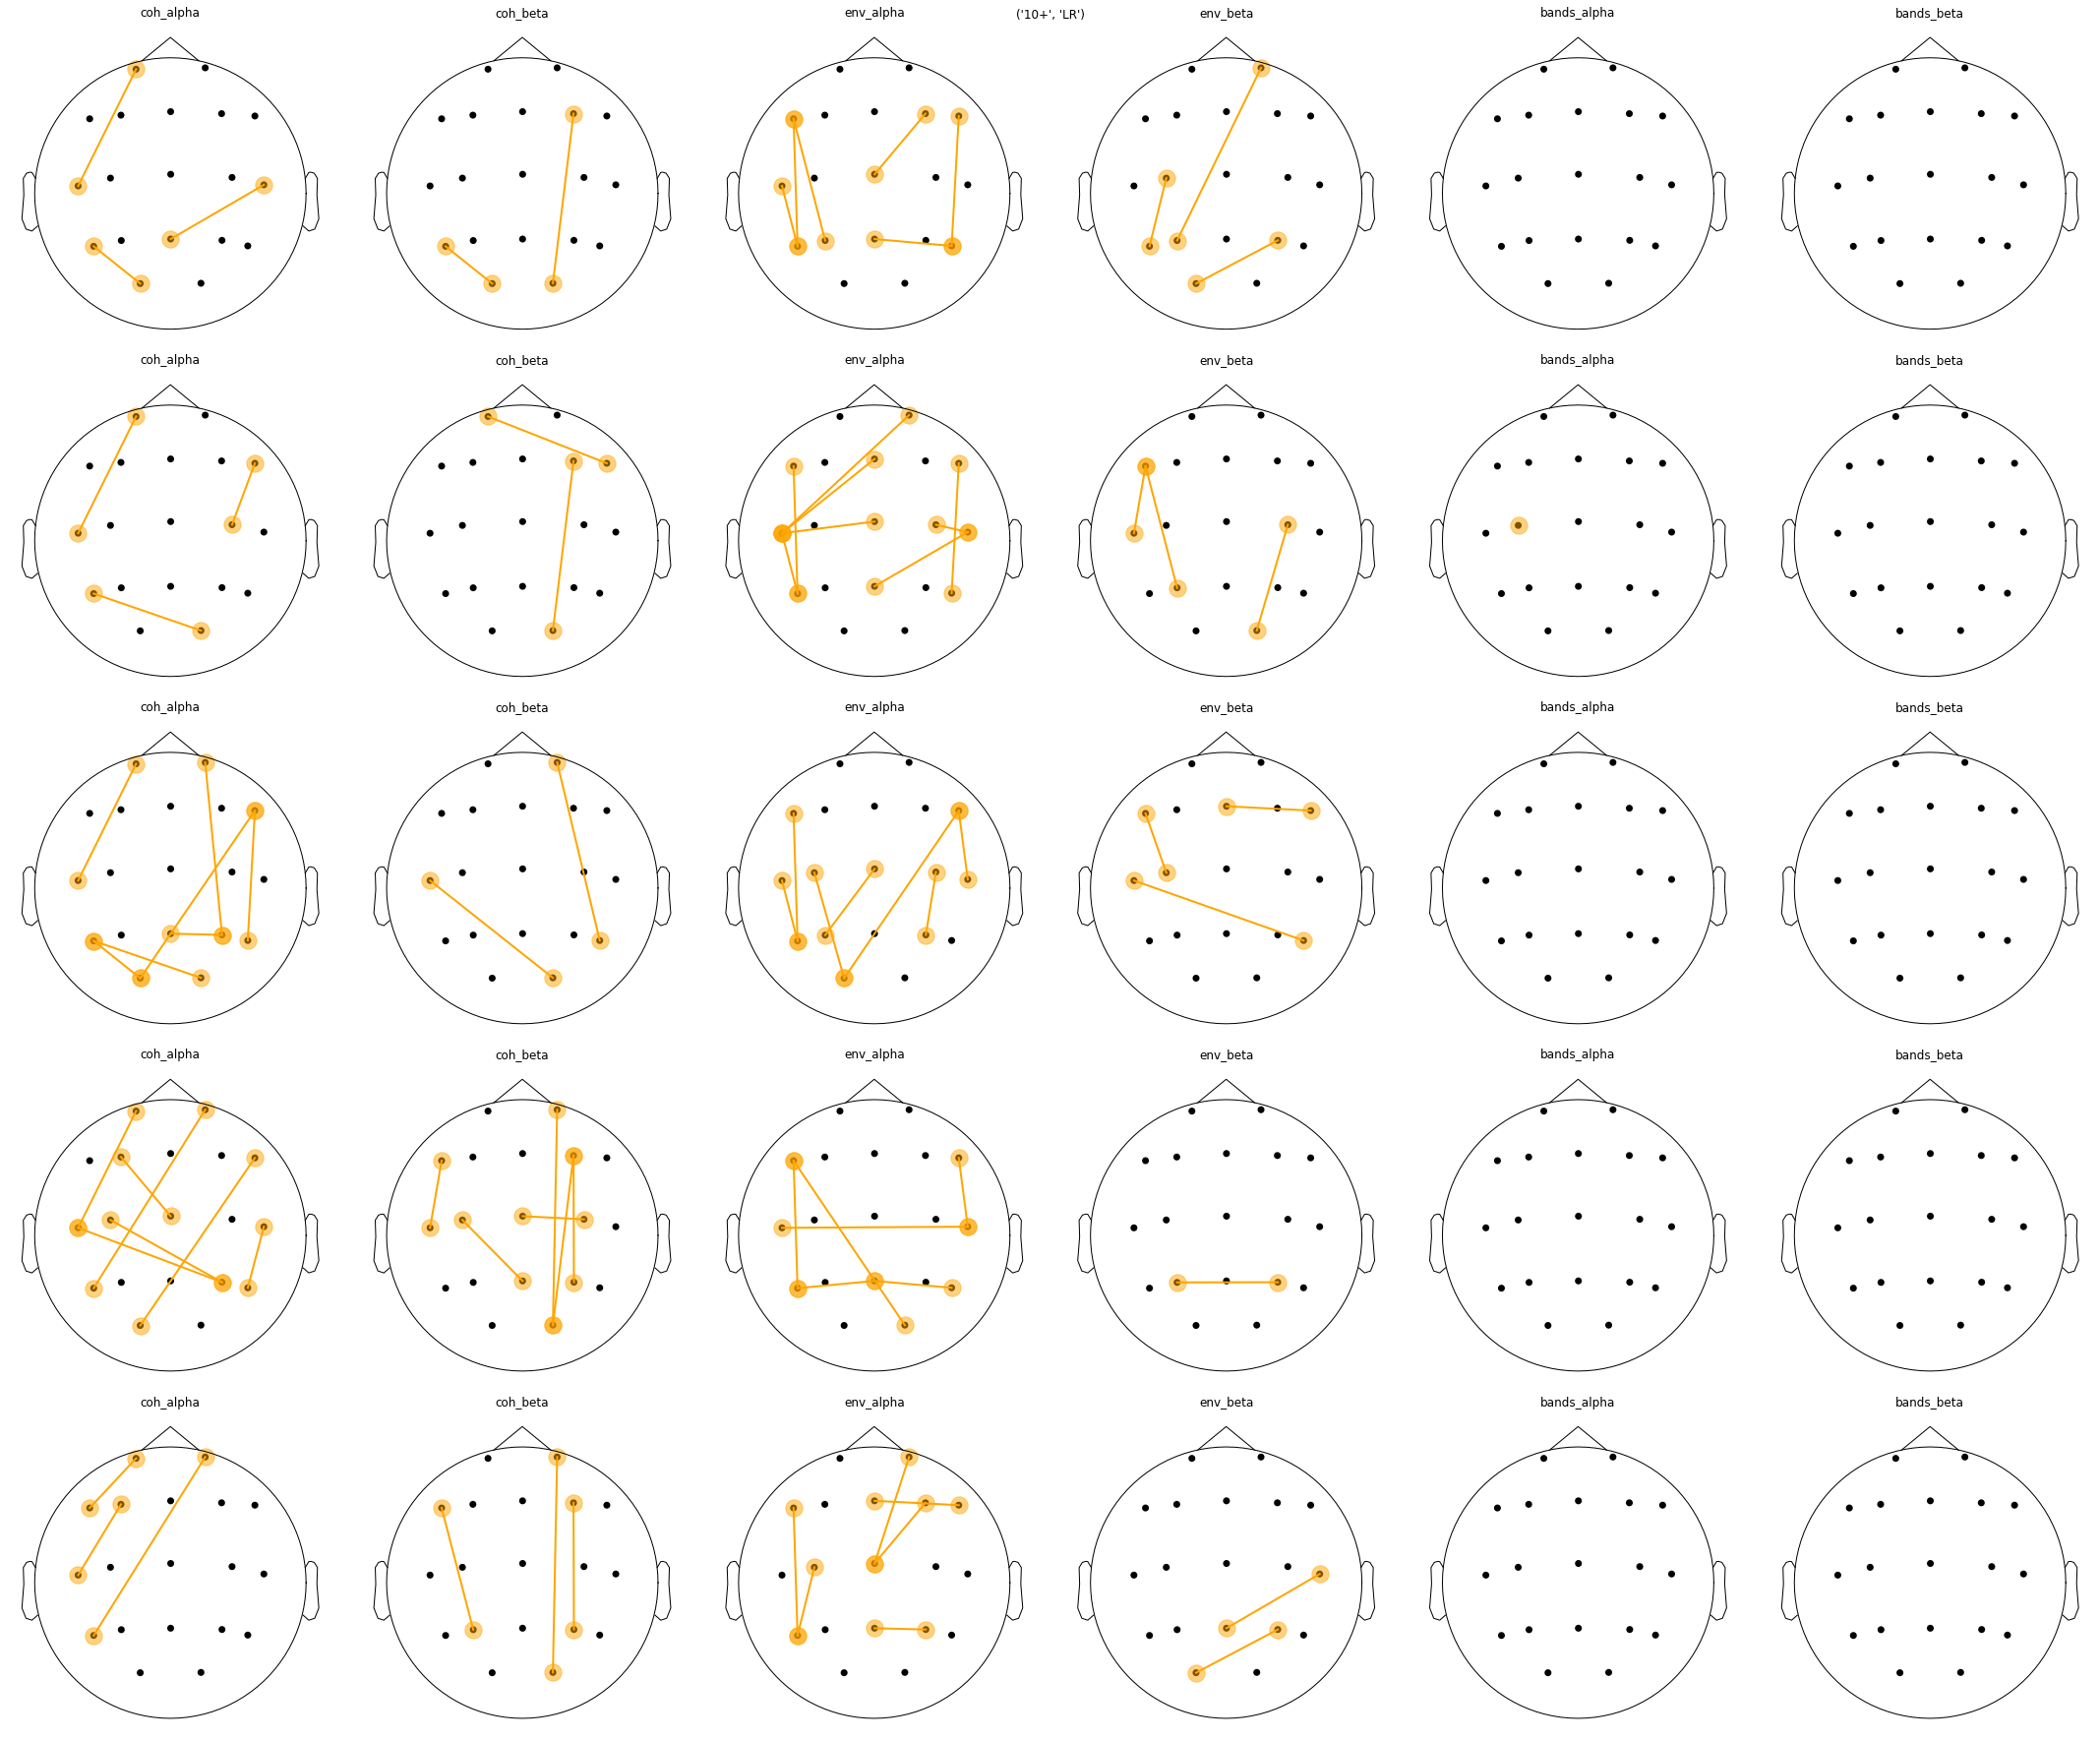

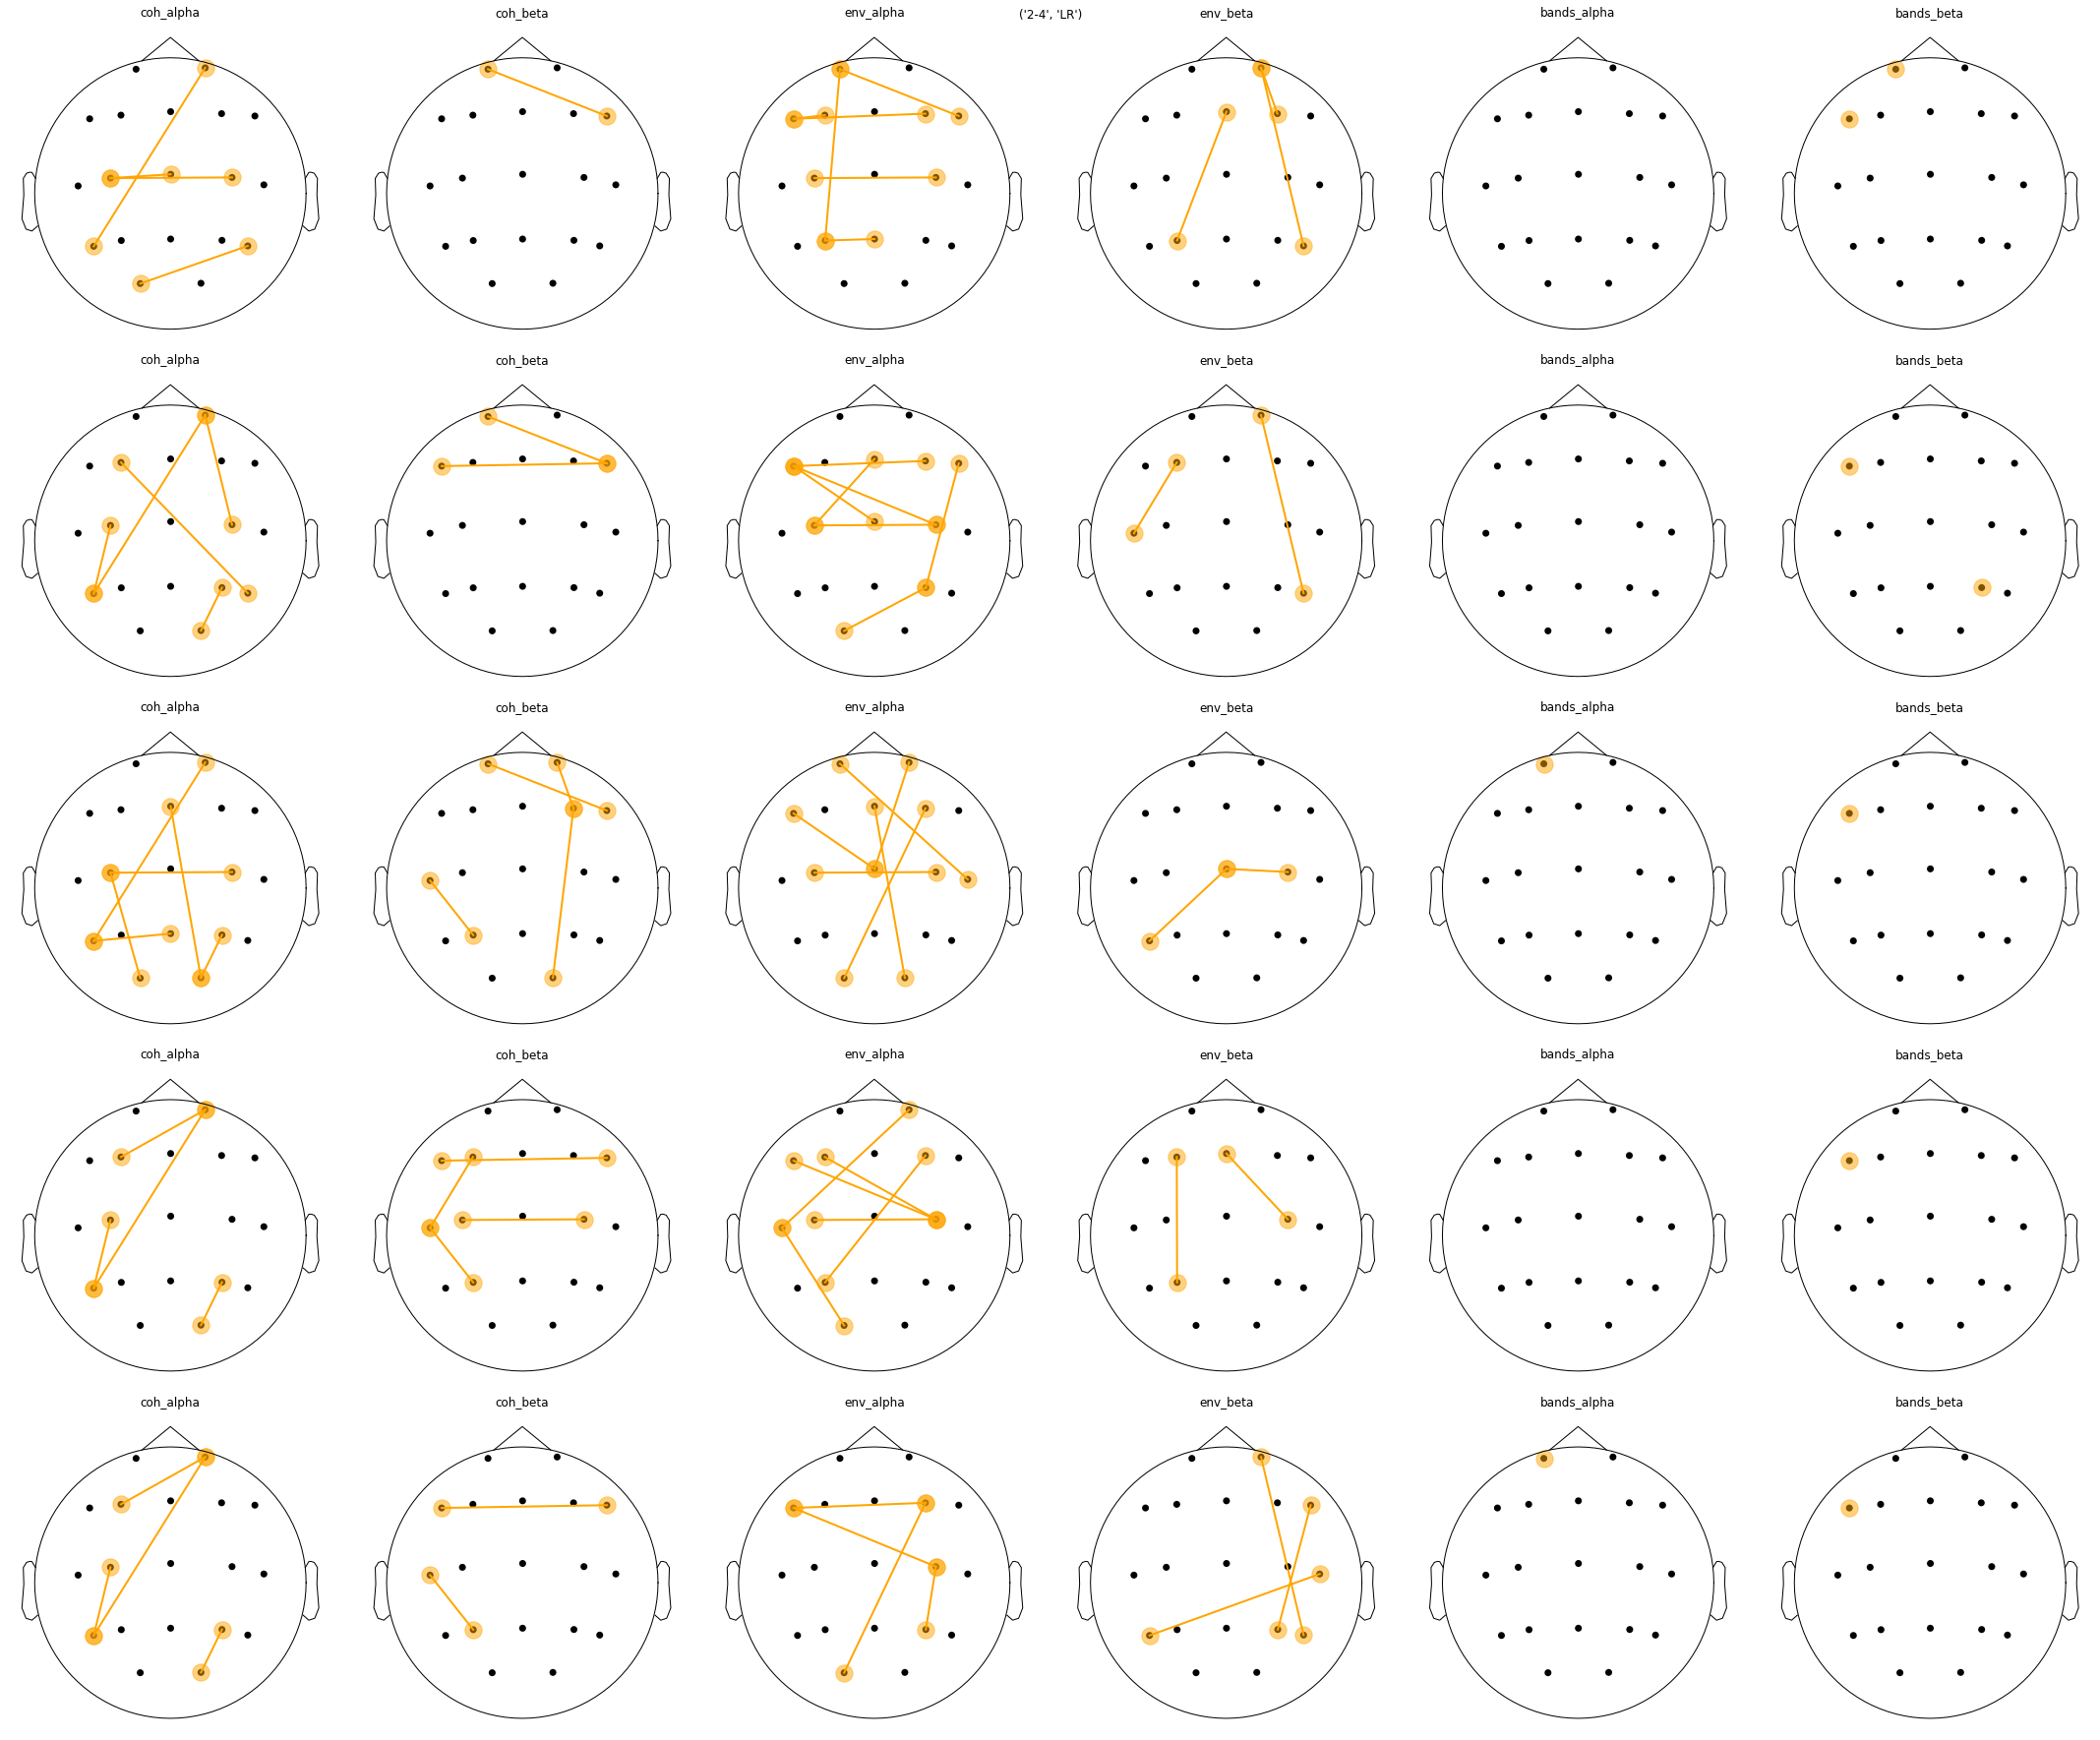

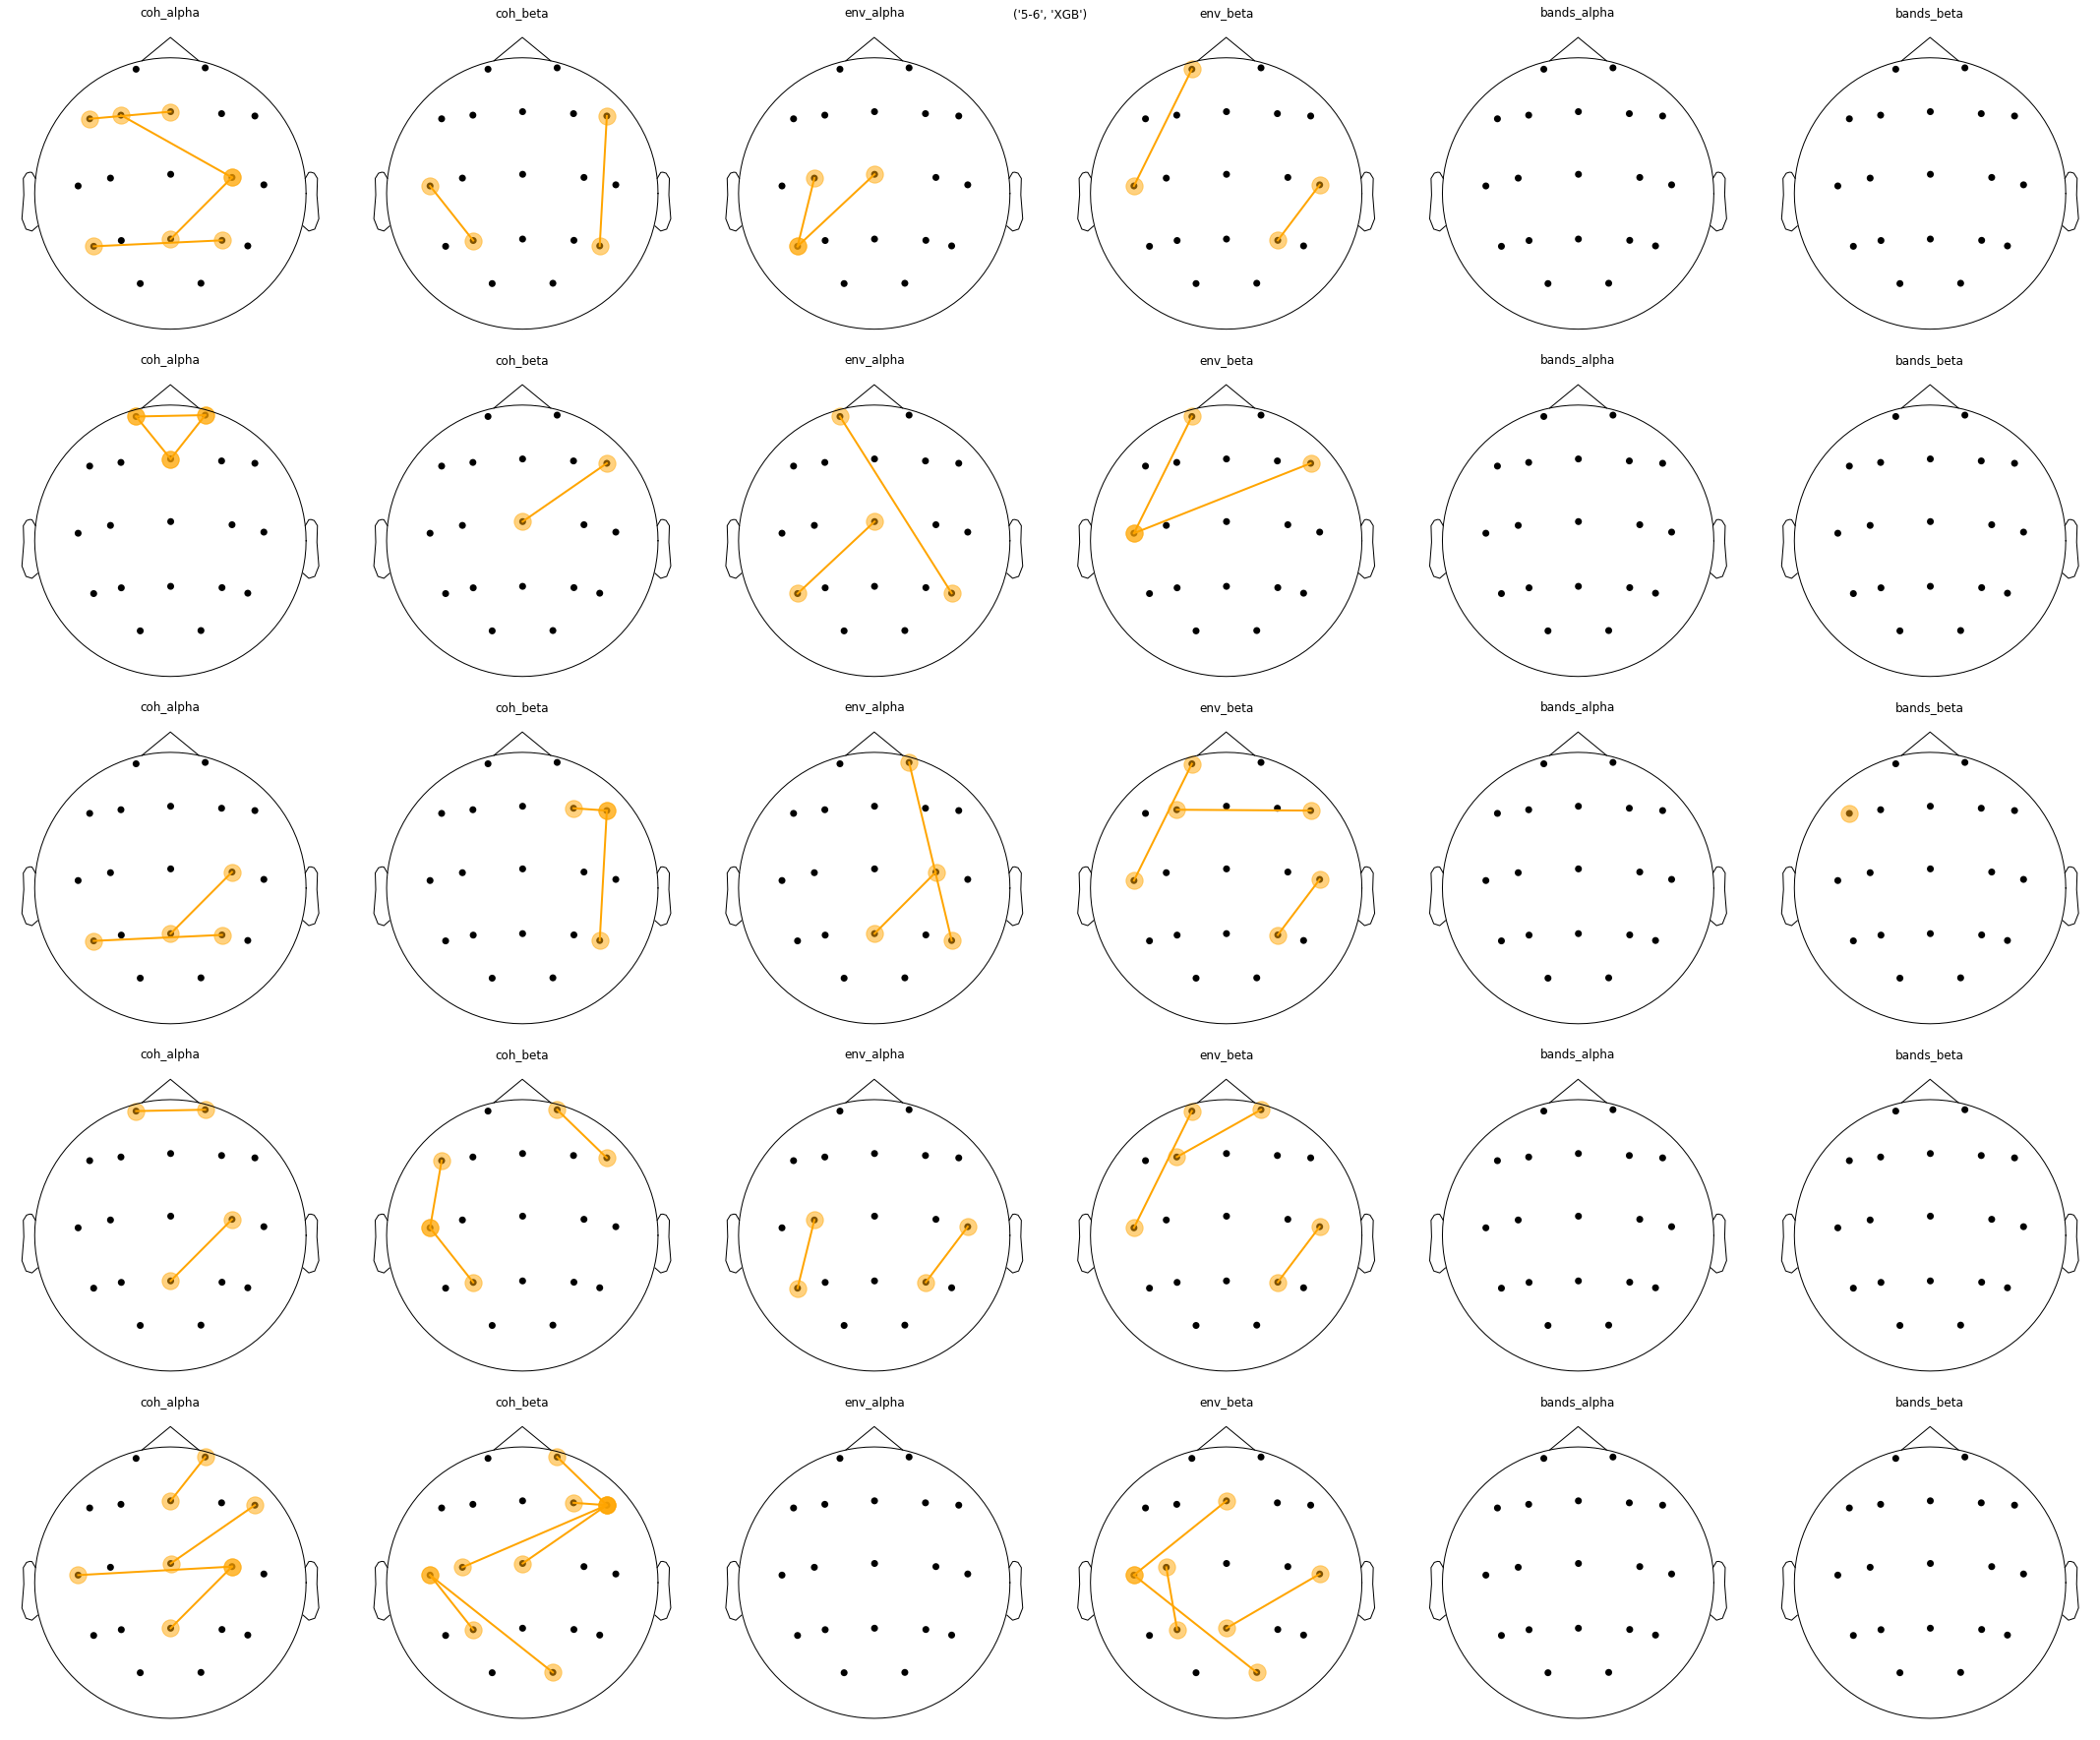

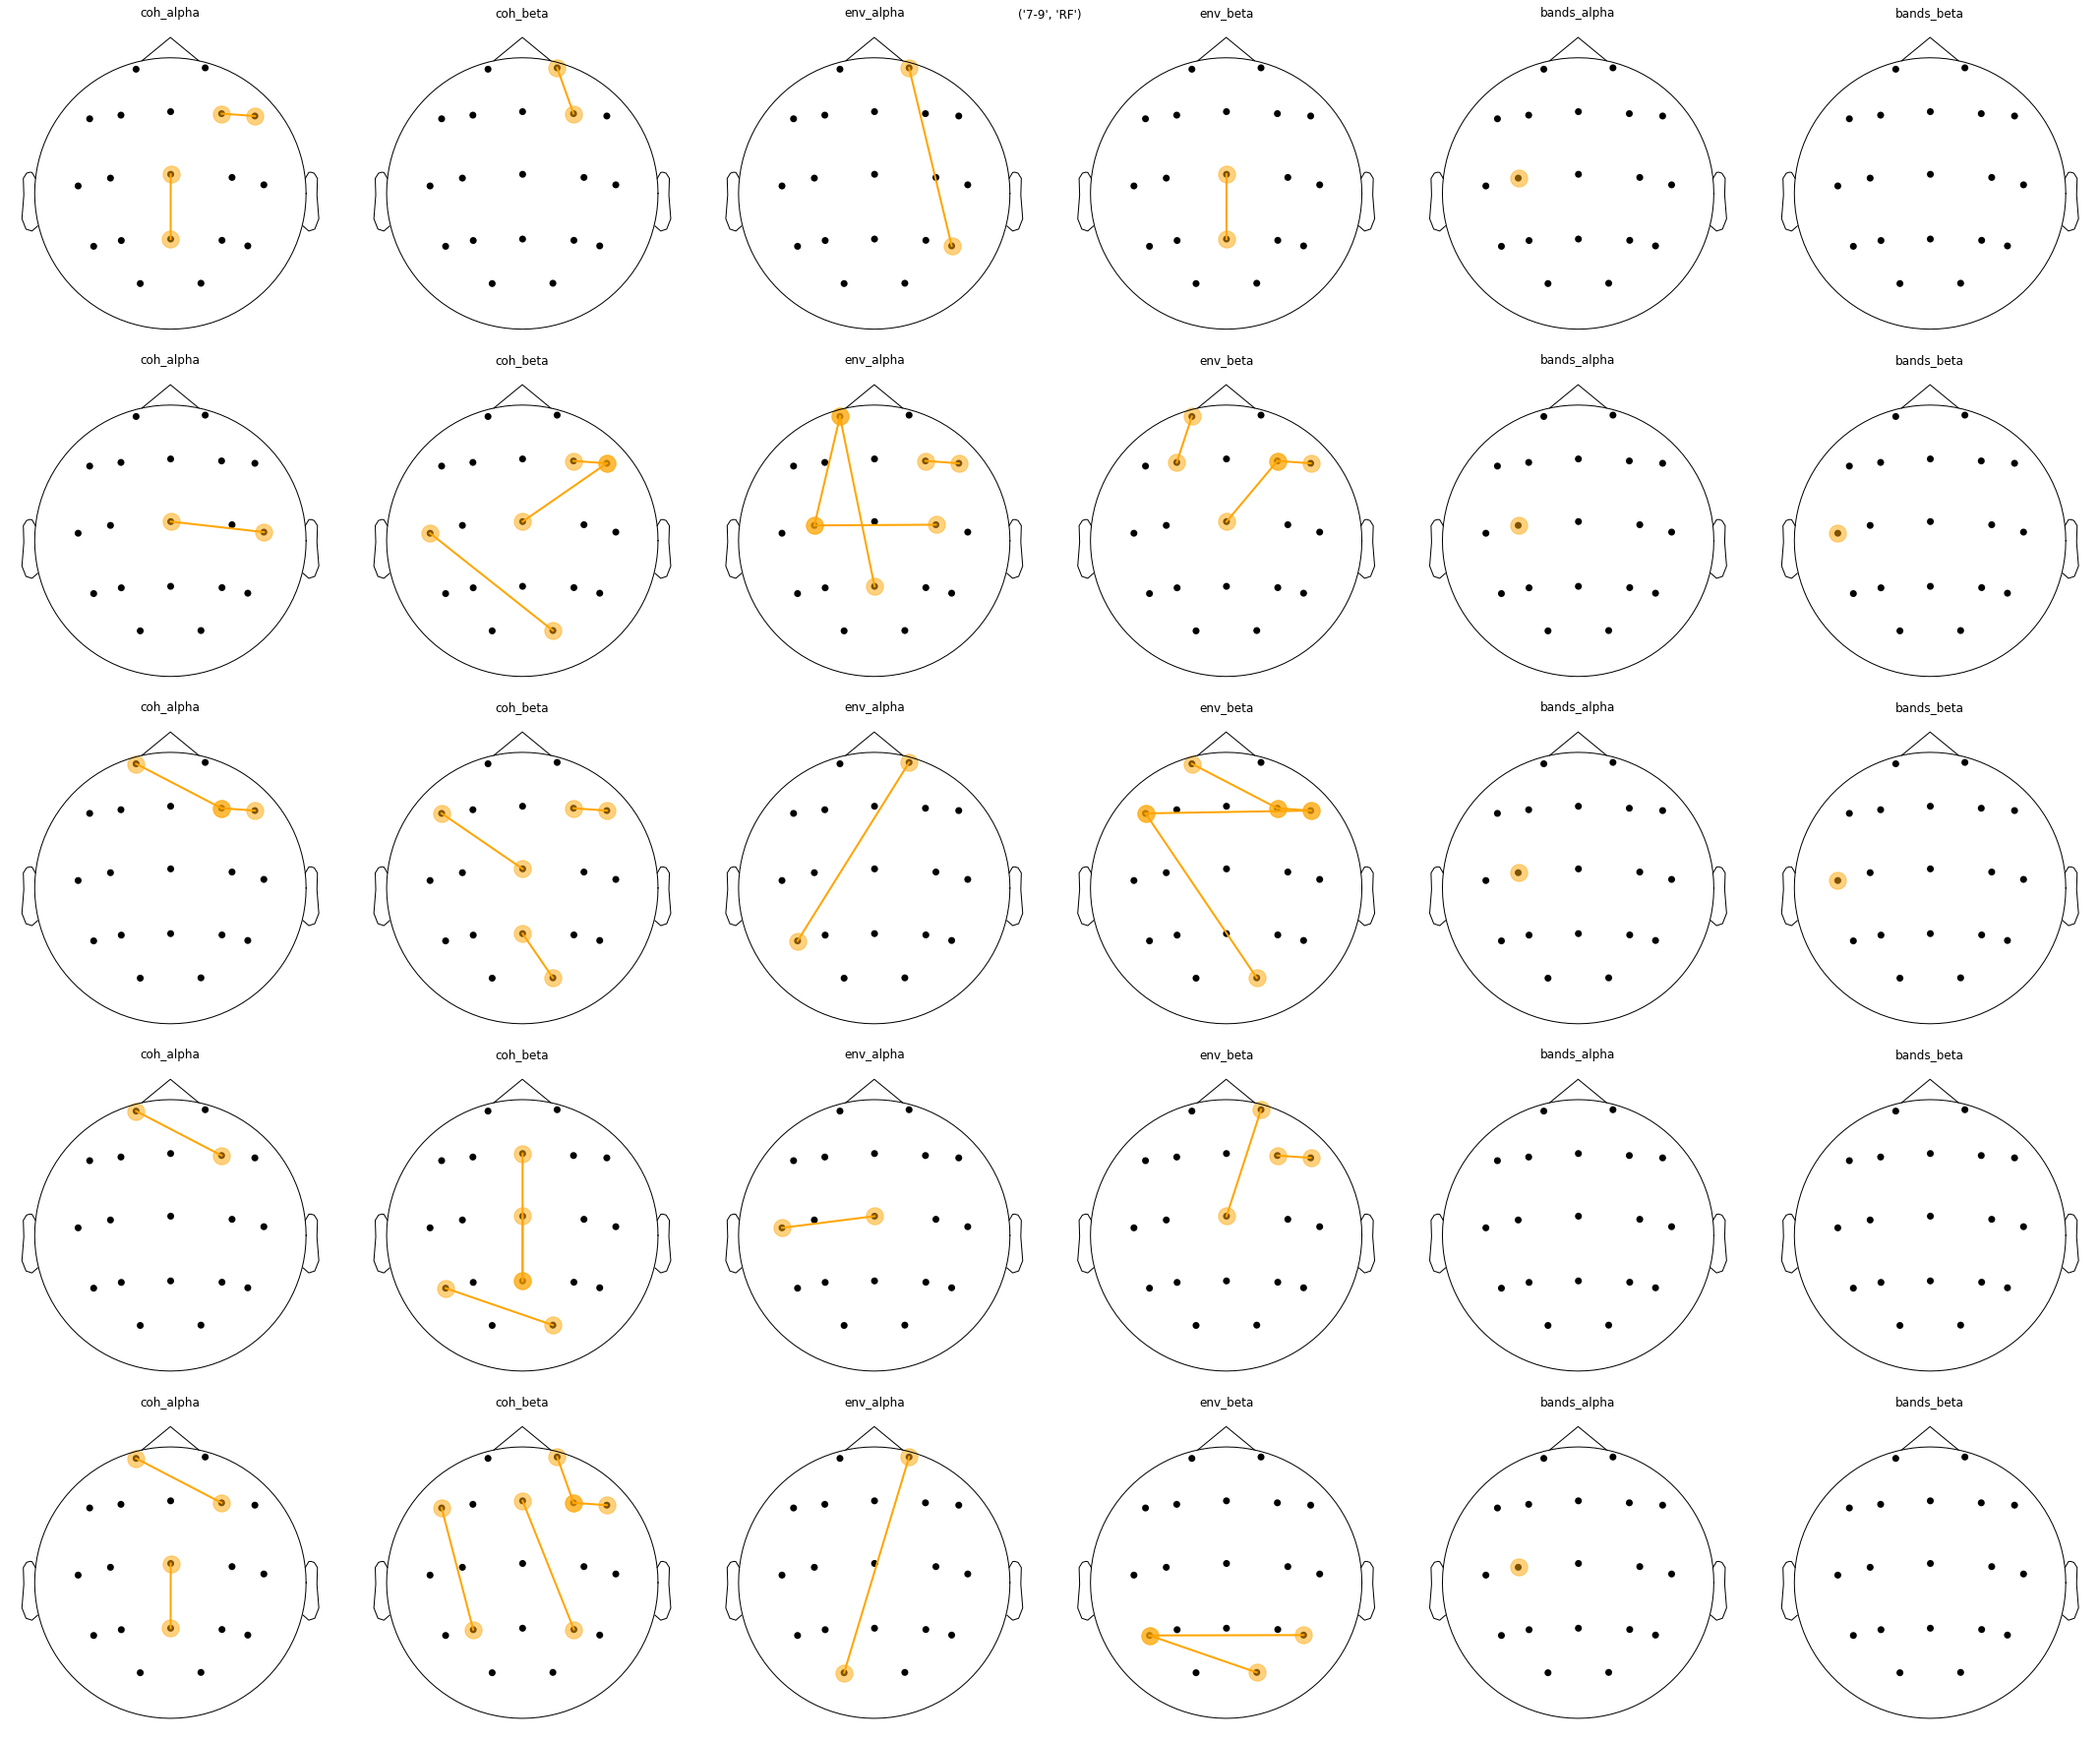

In [17]:
for ag_name in best_models.values:
    s_f = selected_features[ag_name]
    n_folds, n_cols = len(s_f), 6
    fig, axes = plt.subplots(n_folds, n_cols, figsize=(5 * n_cols, 5 * n_folds))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, fold in enumerate(s_f):
        plot_features_fold(fold, axes[i])
    fig.suptitle(ag_name)
    plt.tight_layout()
    # plt.savefig(f'../images/asd/({ag_name})_folds.jpg')

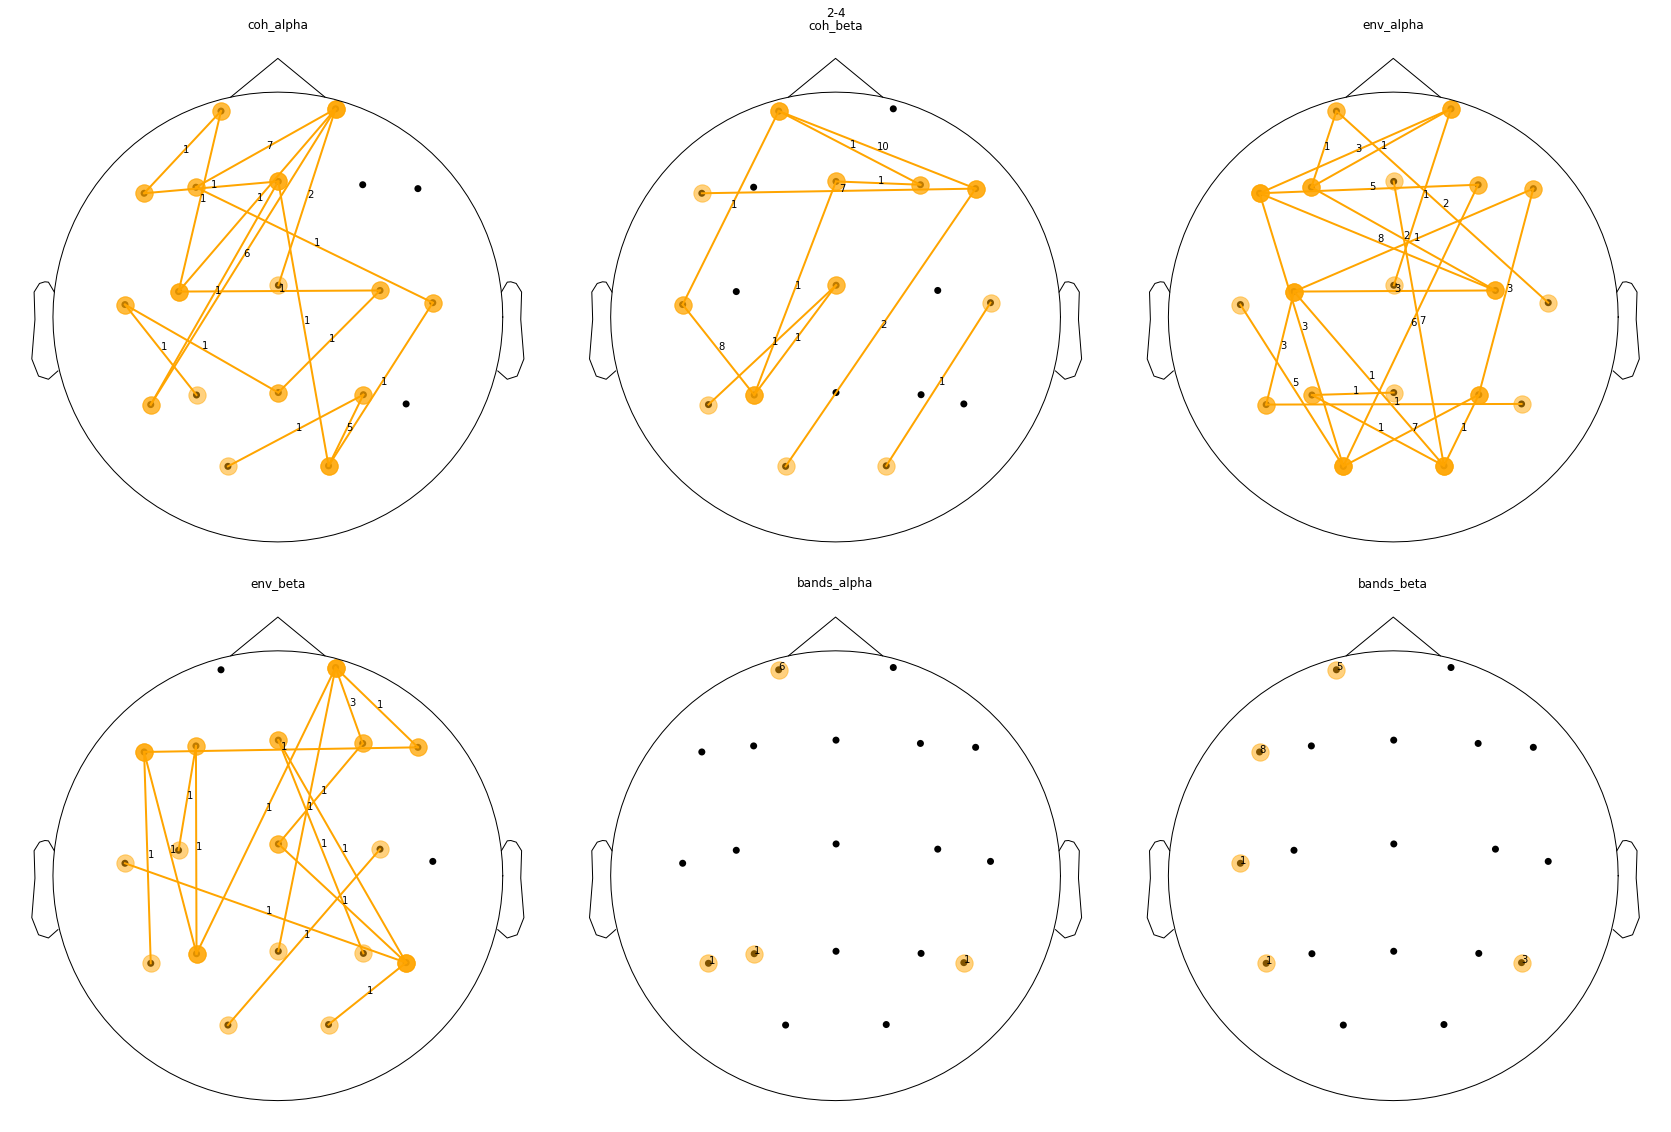

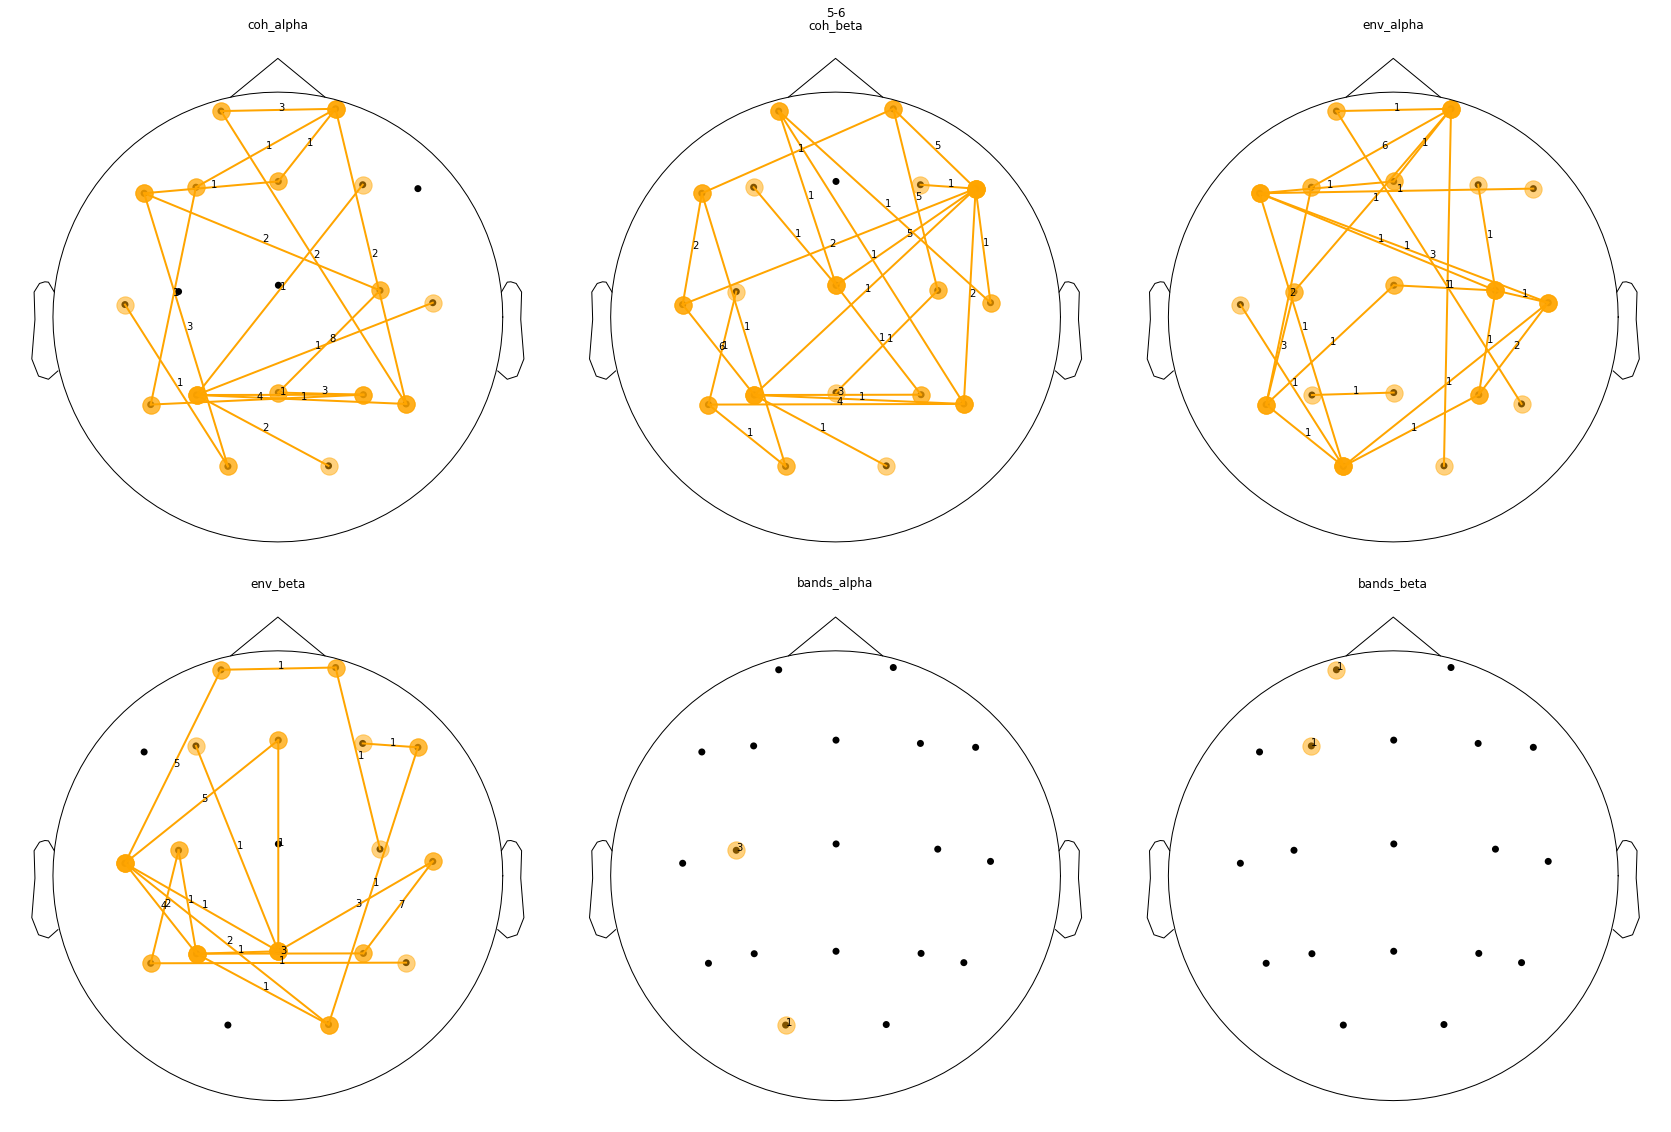

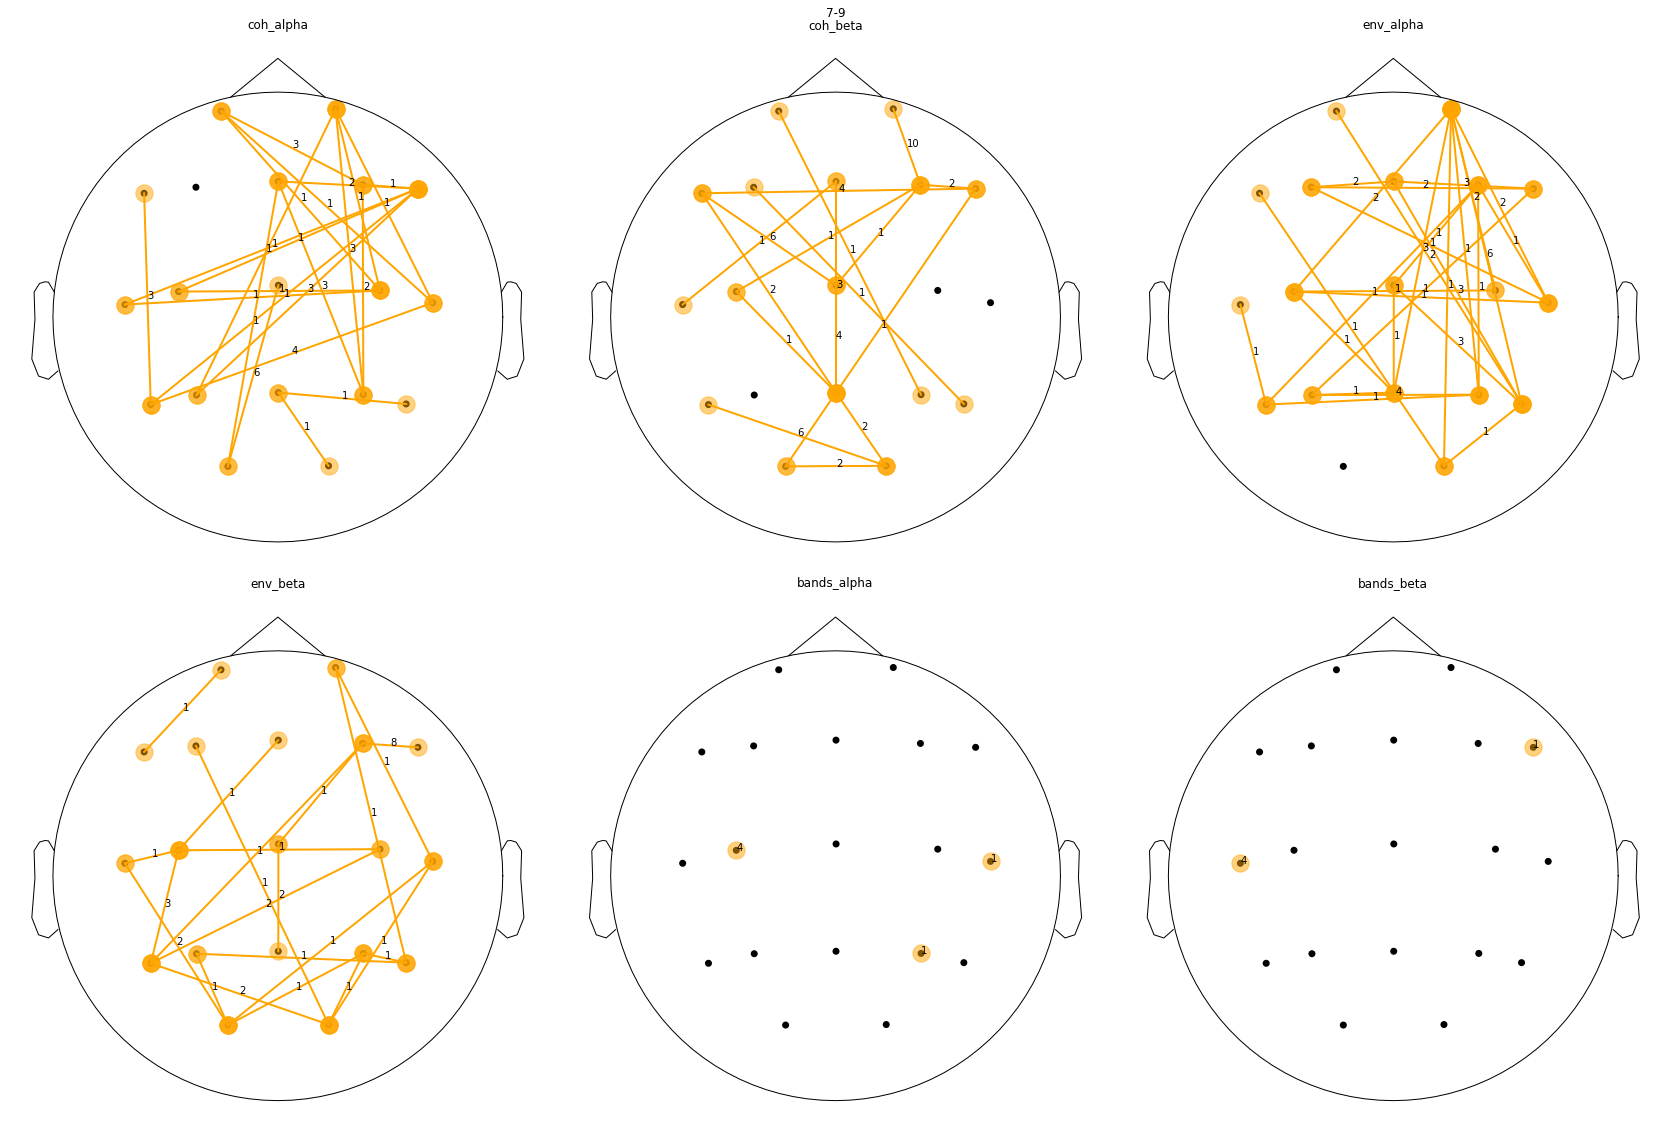

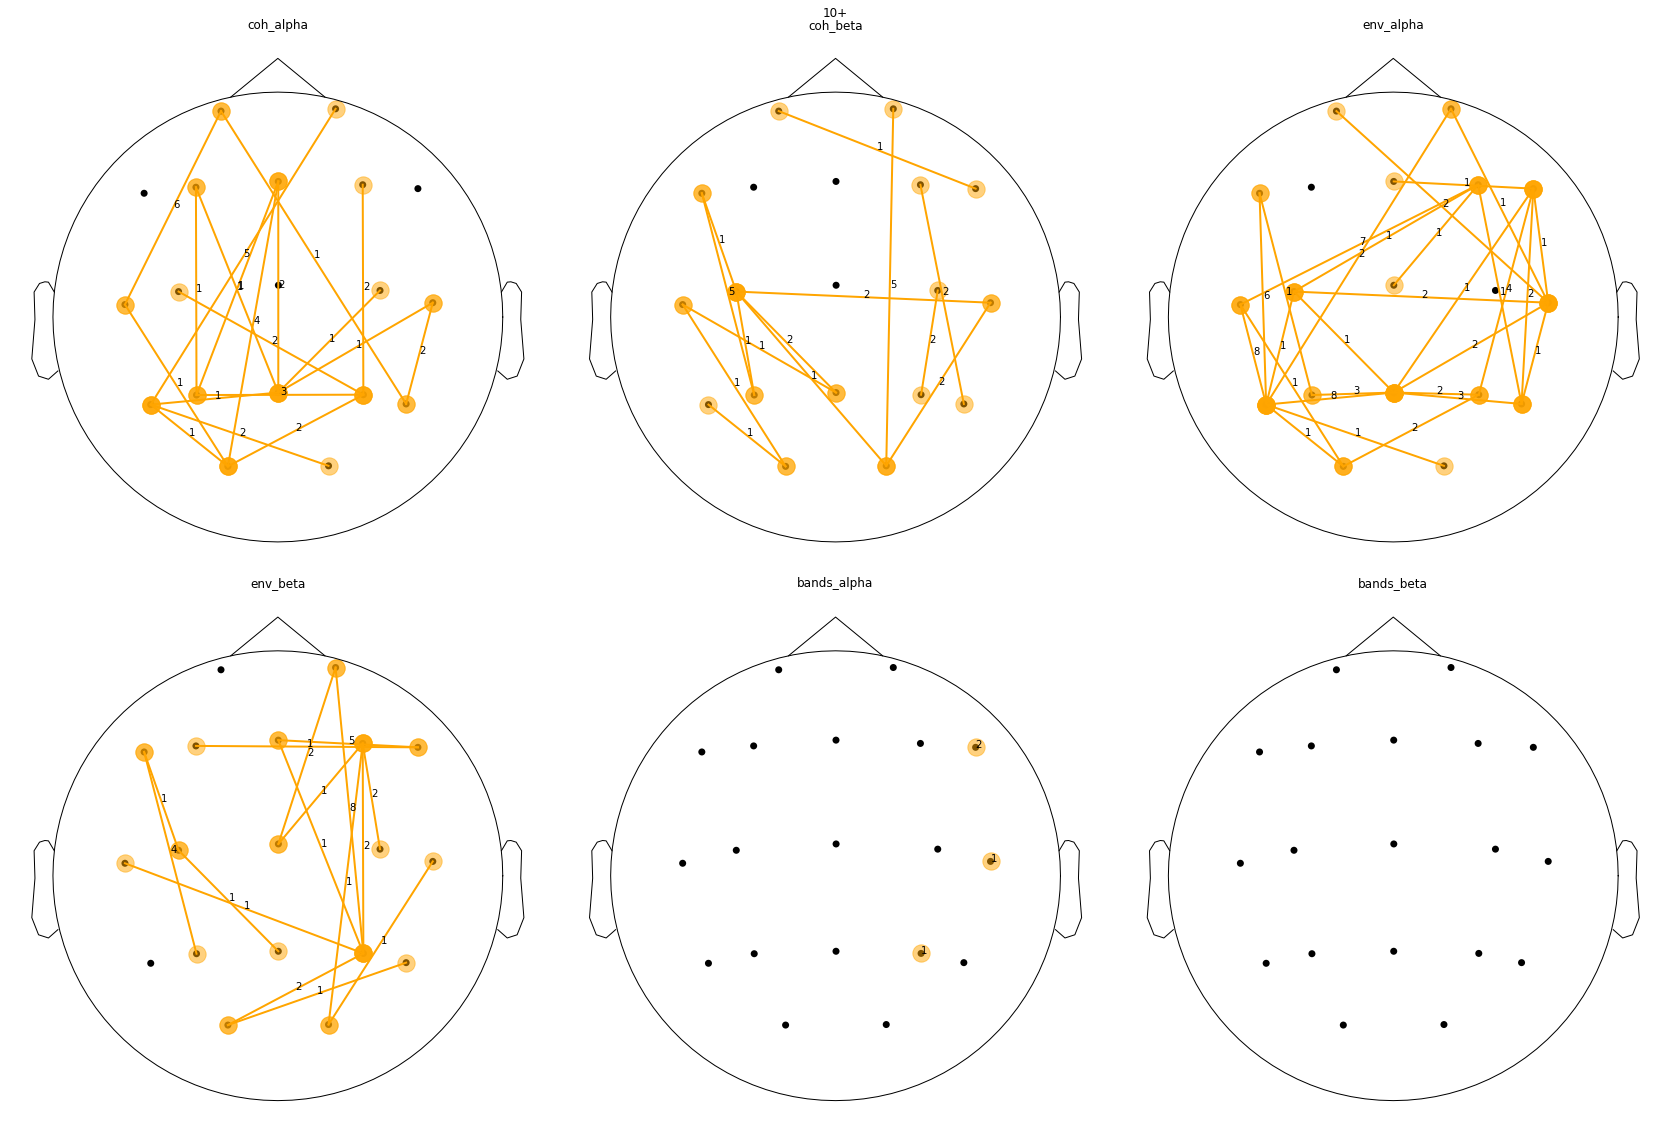

In [ ]:
for ag_name, c in counts.items():
    fig, axes = plt.subplots(2, 3, figsize=[24, 16])
    plt.subplots_adjust(wspace=0)
    plot_featues_agg(c, flatten(axes))
    fig.suptitle(ag_name)
    plt.tight_layout()
    # plt.savefig(f'../images/asd/({ag_name})_combined.jpg')